In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pylab as plt
colors = sns.color_palette()
%matplotlib inline

In [3]:
data_path = '/disk/ru'
streams = pd.read_json(os.path.join(data_path, 'streams'), lines=True)
streams['timestamp'] = pd.to_datetime(streams['timestamp'], format='%Y-%m-%d %H:%M:%S')
streams.sort_values(by=['timestamp'], inplace=True)
streams.reset_index(inplace=True, drop=True)
streams['delta'] = streams.groupby(['user_id'])['timestamp'].diff().dt.total_seconds()

streams.head()

,device_type,length,os,timestamp,track_id,user_id,delta
0,desktop,254,Linux,2017-09-09,2318538f5412b3e87cf335fb667c0e7f121ae830,bab3607bf601e7e681012f206b62b4b39ee7023c,NaN
1,mobile,179,iOS,2017-09-09,dc1dd219d560a964281d777ad34a62af288a1de8,2622b170e9ddcb7d05946e914ad6fe61cee6ea63,NaN
2,mobile,242,Android,2017-09-09,d6aa6ac360c555ef96830404a0b66cc2a4d6fb8d,637d4c31a14e65cf77a6bd75a2aa605e8655b244,NaN
3,mobile,214,iOS,2017-09-09,c0dd8f4afbd640483b2746bc7287a52383e63b72,885085495b80cb431f149b3d82fb4bcc44ea7469,NaN
4,mobile,249,Android,2017-09-09,212eebd1e92303a5e0c43141561a724d3b47b549,5e94bc2ccd18805ba6b1747cc5d3260020425b00,NaN


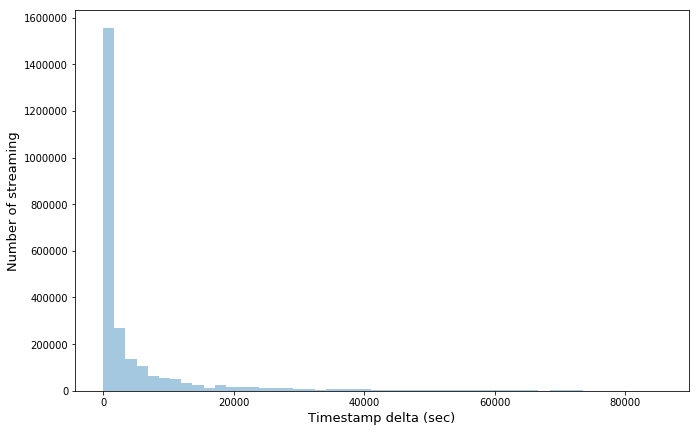

In [4]:
# Plot delta distribution
plt.figure(figsize=(11, 7))
sns.distplot(streams['delta'].dropna(), kde=False)
plt.xlabel('Timestamp delta (sec)', size=13)
plt.ylabel('Number of streaming', size=13)
plt.show()

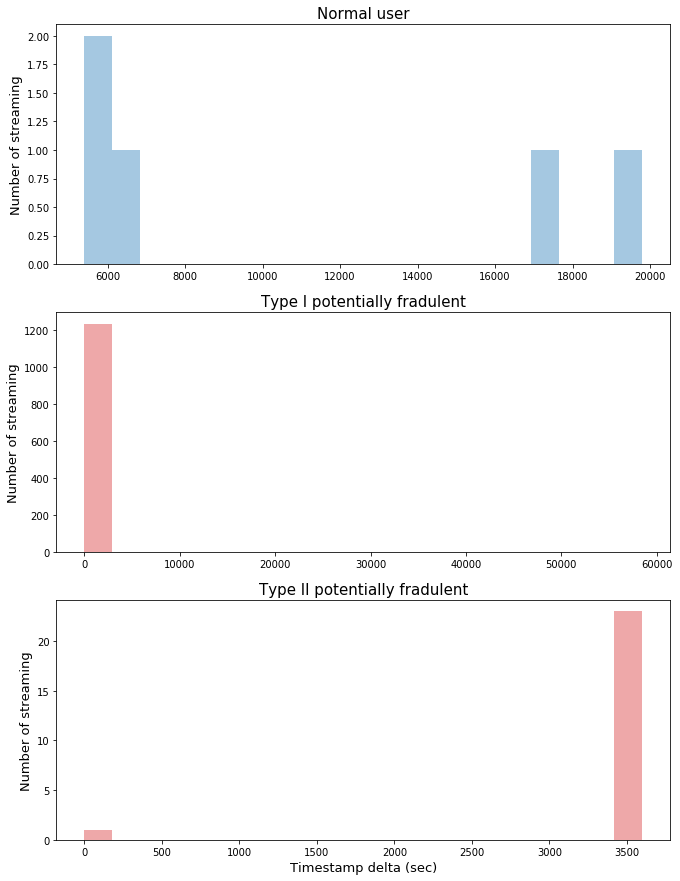

In [5]:
# Three kinds of user

fig, axes = plt.subplots(nrows=3, figsize=(11, 15))
plt.subplot(3,1,1)
sns.distplot(streams['delta'].loc[streams['user_id']=='5b6d51824857416e5ae15792abd0103fd91618f1'].dropna(), 
             kde=False, bins=20)
plt.title('Normal user', fontsize=15)
plt.xlabel('', size=13)
plt.ylabel('Number of streaming', size=13)

plt.subplot(3,1,2)
sns.distplot(streams['delta'].loc[streams['user_id']=='c41f7f98ec5c0fdd81c23f2a43ad3d6e9b85cade'].dropna(), 
             kde=False, bins=20, color=colors[3])
plt.title('Type I potentially fradulent', fontsize=15)
plt.xlabel('', size=13)
plt.ylabel('Number of streaming', size=13)

plt.subplot(3,1,3)
sns.distplot(np.append(streams['delta'].loc[streams['user_id']=='58d02c067e05aaa67404d3b6cb50233604b48b0f'].dropna().values, 0), 
             kde=False, bins=20, color=colors[3])
plt.title('Type II potentially fradulent', fontsize=15)
plt.xlabel('Timestamp delta (sec)', size=13)
plt.ylabel('Number of streaming', size=13)

plt.show()

In [6]:
index = pd.date_range('2017-09-09 00:00:00', '2017-09-09 23:45:00', freq='15min')

data = pd.Series(0, index=index, name='tmp')


data = pd.concat([data, 
                  streams['timestamp'].loc[streams['user_id']=='5b6d51824857416e5ae15792abd0103fd91618f1'].value_counts(), 
                  streams['timestamp'].loc[streams['user_id']=='745cdb4f943954c7cf4bcbe588731b3af4548950'].value_counts(), 
                  streams['timestamp'].loc[streams['user_id']=='aad4e439093860edfbe9b3dc8c68963a712b37b0'].value_counts(), 
                  streams['timestamp'].loc[streams['user_id']=='d31bd3a4461ed83828f18ae59537fd6264a5eec0'].value_counts(), 
                  streams['timestamp'].loc[streams['user_id']=='58d02c067e05aaa67404d3b6cb50233604b48b0f'].value_counts(), 
                  streams['timestamp'].loc[streams['user_id']=='b6d1cb74cc340fc889756289296db845323e0b46'].value_counts(), 
                 ], axis=1)
data.drop(['tmp'], axis=1, inplace=True)
data.columns = ['normal_user_1', 'normal_user_2', 'normal_user_3', 
                'abnormal_user_1', 'abnormal_user_2', 'abnormal_user_3']

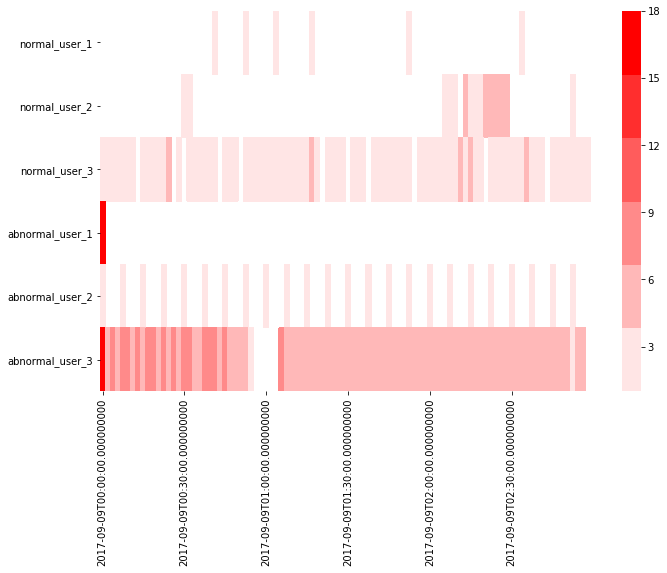

In [7]:
cmap = sns.light_palette("red")

plt.figure(figsize=(11, 7))
sns.heatmap(data.T, cmap=cmap)
plt.locator_params(axis='x', nbins=6)
plt.show()

In [8]:
# Track legth and 
data = streams.groupby(['track_id'])['length'].agg({'time': len, 'mean_len': np.mean})

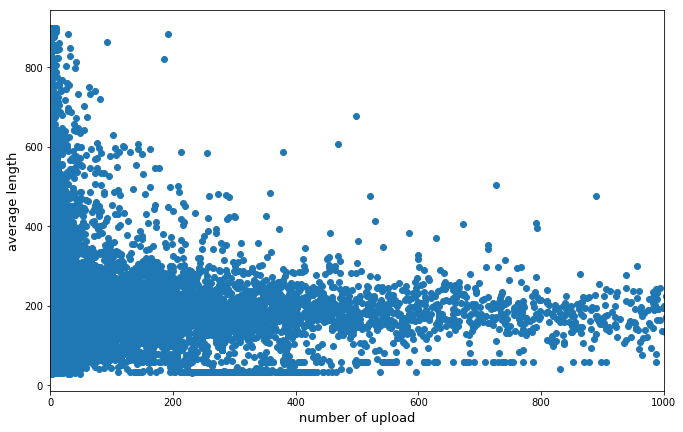

In [9]:
plt.figure(figsize=(11, 7))
plt.scatter(x=data['time'], y=data['mean_len'], color=colors[0])
plt.xlabel('number of upload', size=13)
plt.ylabel('average length', size=13)
plt.xlim((0, 1000))
plt.show()